In [2]:
library(RPostgreSQL)
library(utils)
library(reshape2)
library(dplyr)
library(ggalluvial)

Loading required package: DBI

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2


In [3]:
col=read.delim("../subnetwork_colours.csv",sep=",",stringsAsFactors=FALSE)
col2=as.character(col$colour)
names(col2)=col$network
col2

I        II       III        IV         V        VI       VII      VIII 
"#999999" "#FFE529" "#5A6A99" "#FF7F00" "#E486B7" "#6B886E" "#E41A1C" "#CA9A2C" 
       IX         X        XI 
"#AD5882" "#C66764" "#449B76"

In [4]:
con = dbConnect(PostgreSQL(),dbname = 'yourdb', 
                 host = 'yourhost',
                 port = 0000)

In [5]:
p=dbGetQuery(con,"select * from physcogrn.paper_gene_sets")
head(p)

,set,geneid
,<chr>,<chr>
1,TF with deregulated target,Pp3c1_12940.mRNA
2,TF with deregulated target,Pp3c1_14230.mRNA
3,TF with deregulated target,Pp3c1_14480.mRNA
4,TF with deregulated target,Pp3c1_15290.mRNA
5,TF with deregulated target,Pp3c1_15410.mRNA
6,TF with deregulated target,Pp3c1_15560.mRNA


In [6]:
table(p$set)


          activator target           repressor target 
                      2445                       2639 
TF with deregulated target                WT 3-5 days 
                       714                       4744 
              WT 9-14 days WT gametophyte development 
                      5628                      14939 

In [7]:
intersect(p[p$set=="activator target","geneid"],p[p$set=="repressor target","geneid"])
intersect(p[p$set=="WT 3-5 days","geneid"],p[p$set=="WT 9-14 days","geneid"])
throughout=setdiff(p[p$set=="WT gametophyte development","geneid"],union(p[p$set=="WT 3-5 days","geneid"],p[p$set=="WT 9-14 days","geneid"]))
D2=p[p$set=="WT 3-5 days","geneid"]
D3=p[p$set=="WT 9-14 days","geneid"]
time=data.frame(geneid=D2,development="WT 3-5 days",stringsAsFactors=FALSE)
time=rbind(time, data.frame(geneid=D3,development="WT 9-14 days",stringsAsFactors=FALSE))
time=rbind(time, data.frame(geneid=throughout,development="WT 3-14 days",stringsAsFactors=FALSE))
head(time)

character(0)

character(0)

,geneid,development
,<chr>,<chr>
1,Pp3c18_20030.mRNA,WT 3-5 days
2,Pp3c3_31560.mRNA,WT 3-5 days
3,Pp3c1_15390.mRNA,WT 3-5 days
4,Pp3c16_4180.mRNA,WT 3-5 days
5,Pp3c6_19920.mRNA,WT 3-5 days
6,Pp3c2_21720.mRNA,WT 3-5 days


In [8]:
d=subset(p, set %in% c("activator target","repressor target","TF with deregulated target"))
names(d)[1]=("mutant_pattern")
d=d[,c(2,1)]
head(d)

,geneid,mutant_pattern
,<chr>,<chr>
1,Pp3c1_12940.mRNA,TF with deregulated target
2,Pp3c1_14230.mRNA,TF with deregulated target
3,Pp3c1_14480.mRNA,TF with deregulated target
4,Pp3c1_15290.mRNA,TF with deregulated target
5,Pp3c1_15410.mRNA,TF with deregulated target
6,Pp3c1_15560.mRNA,TF with deregulated target


In [9]:
nrow(d)
nrow(time)
P=merge(d,time,by="geneid",all.x=TRUE,all.y=FALSE)
nrow(P)
P$development[is.na(P$development)]="unchanged"
table(P$mutant_pattern,P$development)

[1] 5798

[1] 15639

[1] 5798

                            
                             unchanged WT 3-14 days WT 3-5 days WT 9-14 days
  activator target                 578          680         393          794
  repressor target                 703          831         765          340
  TF with deregulated target       264          142         103          205

In [10]:
a=dbGetQuery(con,"select * from physcogrn.final_dek1_targets")
a1=unique(a$regulatorygene)
a2=unique(a$targetgene)

A=data.frame(geneid=setdiff(a1,a2),DEK1_target="direct",stringsAsFactors=FALSE)
A=rbind(A,data.frame(geneid=setdiff(a2,a1),DEK1_target="indirect",stringsAsFactors=FALSE))
A=rbind(A,data.frame(geneid=intersect(a2,a1),DEK1_target="both",stringsAsFactors=FALSE))
table(A$DEK1_target)
nrow(P)
P=merge(P,A,by="geneid",all.x=TRUE,all.y=FALSE)
P$DEK1_target[is.na(P$DEK1_target)]="no"
nrow(P)
head(P)


    both   direct indirect 
      85      446     3594 

[1] 5798

[1] 5798

,geneid,mutant_pattern,development,DEK1_target
,<chr>,<chr>,<chr>,<chr>
1,Pp3c1_10200.mRNA,repressor target,unchanged,indirect
2,Pp3c1_10220.mRNA,repressor target,WT 9-14 days,indirect
3,Pp3c1_10400.mRNA,activator target,unchanged,indirect
4,Pp3c1_10760.mRNA,activator target,WT 9-14 days,indirect
5,Pp3c1_10830.mRNA,activator target,unchanged,indirect
6,Pp3c1_11030.mRNA,repressor target,WT 3-5 days,no


In [11]:
nrow(P)

[1] 5798

In [12]:
a=dbGetQuery(con,"select * from physcogrn.dek1dge where analysis='number_buds_per_filament' and comparison = 'normal_vs_high' and qval = 0.1")
table(a$direction)
#A=data.frame(geneid=a$geneid,FDGENEA=a$direction,stringsAsFactors=FALSE)
A=data.frame(geneid=a$geneid,overbudding=a$direction,stringsAsFactors=FALSE)
nrow(A)
nrow(P)
P=merge(P,A,by="geneid",all.x=TRUE,all.y=FALSE)
#P$FDGENEA[is.na(P$FDGENEA)]="unchanged"
P$overbudding[is.na(P$overbudding)]="unchanged"
nrow(P)
head(P)


down   up 
1736 1989 

[1] 3725

[1] 5798

[1] 5798

,geneid,mutant_pattern,development,DEK1_target,overbudding
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Pp3c1_10200.mRNA,repressor target,unchanged,indirect,unchanged
2,Pp3c1_10220.mRNA,repressor target,WT 9-14 days,indirect,unchanged
3,Pp3c1_10400.mRNA,activator target,unchanged,indirect,up
4,Pp3c1_10760.mRNA,activator target,WT 9-14 days,indirect,unchanged
5,Pp3c1_10830.mRNA,activator target,unchanged,indirect,unchanged
6,Pp3c1_11030.mRNA,repressor target,WT 3-5 days,no,down


In [13]:
a=dbGetQuery(con,"select * from physcogrn.dek1dge where analysis='percents_filaments_with_buds' and comparison = 'normal_vs_high' and qval = 0.1")
table(a$direction)
#A=data.frame(geneid=a$geneid,FDGENEA=a$direction,stringsAsFactors=FALSE)
A=data.frame(geneid=a$geneid,overbudding_filaments=a$direction,stringsAsFactors=FALSE)
nrow(A)
nrow(P)
P=merge(P,A,by="geneid",all.x=TRUE,all.y=FALSE)
#P$FDGENEA[is.na(P$FDGENEA)]="unchanged"
P$overbudding_filaments[is.na(P$overbudding_filaments)]="unchanged"
nrow(P)
head(P)


down   up 
 585  512 

[1] 1097

[1] 5798

[1] 5798

,geneid,mutant_pattern,development,DEK1_target,overbudding,overbudding_filaments
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Pp3c1_10200.mRNA,repressor target,unchanged,indirect,unchanged,unchanged
2,Pp3c1_10220.mRNA,repressor target,WT 9-14 days,indirect,unchanged,unchanged
3,Pp3c1_10400.mRNA,activator target,unchanged,indirect,up,unchanged
4,Pp3c1_10760.mRNA,activator target,WT 9-14 days,indirect,unchanged,unchanged
5,Pp3c1_10830.mRNA,activator target,unchanged,indirect,unchanged,unchanged
6,Pp3c1_11030.mRNA,repressor target,WT 3-5 days,no,down,unchanged


In [16]:
a=dbGetQuery(con,"select distinct geneid, community as subnetwork from physcogrn.nodes")
nrow(a)
a=subset(a, subnetwork %in% as.character(as.roman(1:11)))
nrow(a)
P=merge(a,P,by="geneid")
nrow(P)

[1] 35706

[1] 35639

[1] 5798

In [17]:
a=dbGetQuery(con,"select distinct geneid,reg_class, name as gene_name, description from physcogrn.gene_name")
nrow(a)
Pna=merge(P,a,by="geneid",all.x=TRUE)
nrow(Pna)

[1] 35707

[1] 5799

In [20]:
pn=P
names(pn)=tolower(names(pn))
dbWriteTable(conn =con, pn,name=c("physcogrn","dek1_major_sets"),row.names=FALSE,overwrite=TRUE)
rm(pn)

[1] TRUE

In [21]:
table(Pna$mutant_pattern)


          activator target           repressor target 
                      2445                       2639 
TF with deregulated target 
                       715 

subnetwork,mutant_pattern,development,n
<chr>,<chr>,<chr>,<int>
I,activator target,unchanged,45
I,activator target,WT 3-14 days,39
I,activator target,WT 3-5 days,11
I,activator target,WT 9-14 days,28
I,repressor target,unchanged,77
I,repressor target,WT 3-14 days,68


,mutant_pattern,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,activator target,54,1,subnetwork,II
2,activator target,21,2,subnetwork,II
3,activator target,191,3,subnetwork,II
4,repressor target,66,4,subnetwork,II
5,repressor target,34,5,subnetwork,II
6,repressor target,88,6,subnetwork,II


NULL

[1] "repressor target"           "activator target"          
[3] "TF with deregulated target"


          repressor target           activator target 
                        30                         30 
TF with deregulated target 
                        28 

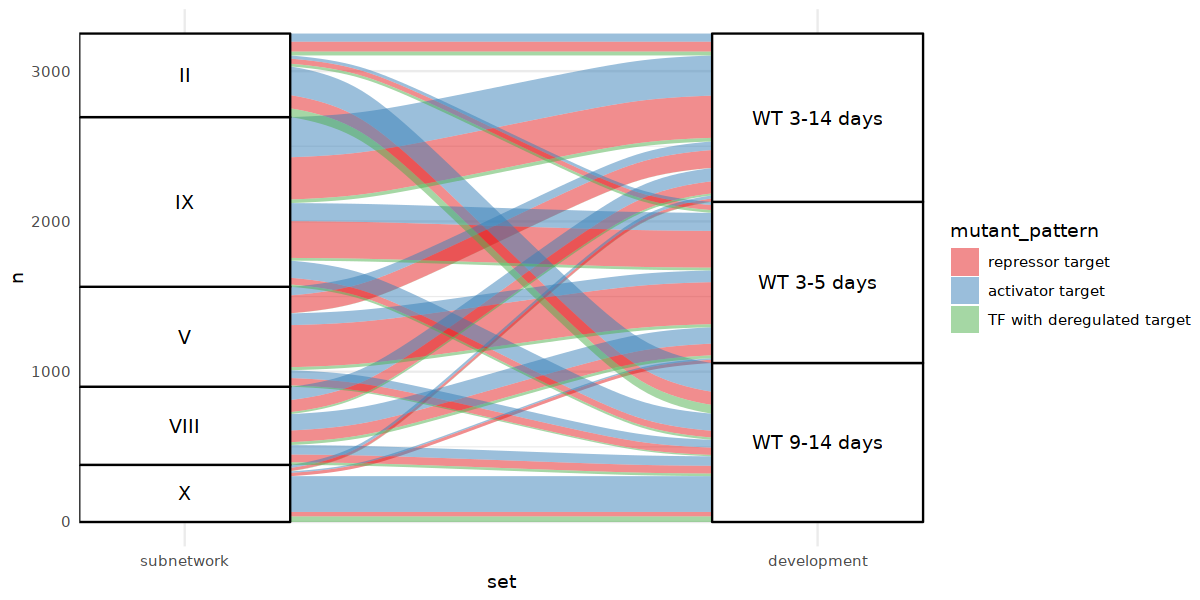

In [24]:
PPa=P %>% count(subnetwork,mutant_pattern,development)
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(subset(PPa,development != "unchanged" & subnetwork %in% c("II","V","VIII","IX","X")))),
                              key = "set",
                              axes = c(1,3))
head(PPP)

levels(PPP$mutant_pattern)
PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
levels(PPP$mutant_pattern)
table(PPP$mutant_pattern)


options(repr.plot.width=10, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

subnetwork,development,DEK1_target,overbudding,n
<chr>,<chr>,<chr>,<chr>,<int>
I,unchanged,both,unchanged,1
I,unchanged,direct,down,3
I,unchanged,direct,unchanged,30
I,unchanged,indirect,down,8
I,unchanged,indirect,unchanged,56
I,unchanged,indirect,up,16


,subnetwork,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,II,2,1,development,WT 3-14 days
2,II,1,2,development,WT 3-14 days
3,II,12,3,development,WT 3-14 days
4,II,24,4,development,WT 3-14 days
5,II,1,5,development,WT 3-5 days
6,II,7,6,development,WT 3-5 days


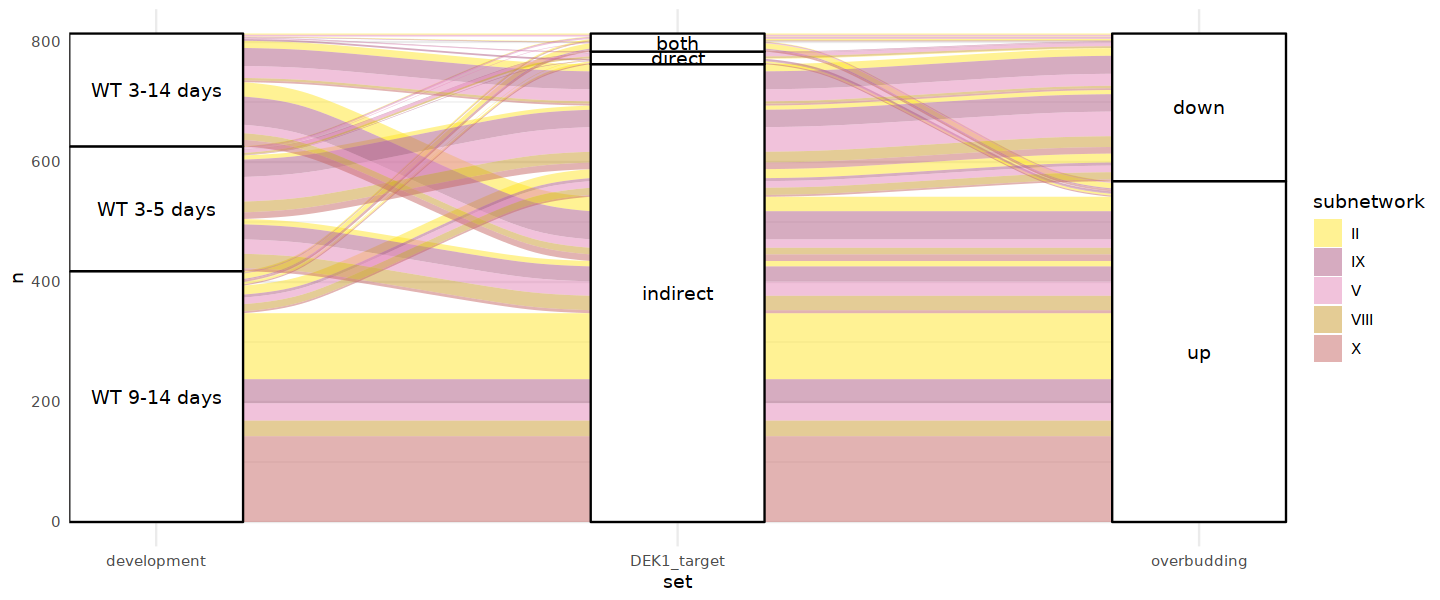

In [25]:
PPa=P %>% count(subnetwork,development,DEK1_target,overbudding)
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(
    subset(PPa,development != "unchanged" & subnetwork %in% c("II","V","VIII","IX","X") & ! DEK1_target == "no" & ! overbudding =="unchanged"))),
                              key = "set",
                              axes = c(2:4))
head(PPP)

#levels(PPP$mutant_pattern)
#PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
#levels(PPP$mutant_pattern)
#table(PPP$mutant_pattern)


options(repr.plot.width=12, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        #scale_fill_brewer(palette="Set1")+
        scale_fill_manual(values=col2) +
        geom_alluvium(aes(fill=subnetwork)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

subnetwork,development,overbudding,DEK1_target,n
<chr>,<chr>,<chr>,<chr>,<int>
II,WT 3-14 days,down,direct,2
II,WT 3-14 days,down,indirect,12
II,WT 3-14 days,up,direct,1
II,WT 3-14 days,up,indirect,24
II,WT 3-5 days,down,direct,1
II,WT 3-5 days,down,indirect,7


,subnetwork,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,II,2,1,development,WT 3-14 days
2,II,12,2,development,WT 3-14 days
3,II,1,3,development,WT 3-14 days
4,II,24,4,development,WT 3-14 days
5,II,1,5,development,WT 3-5 days
6,II,7,6,development,WT 3-5 days


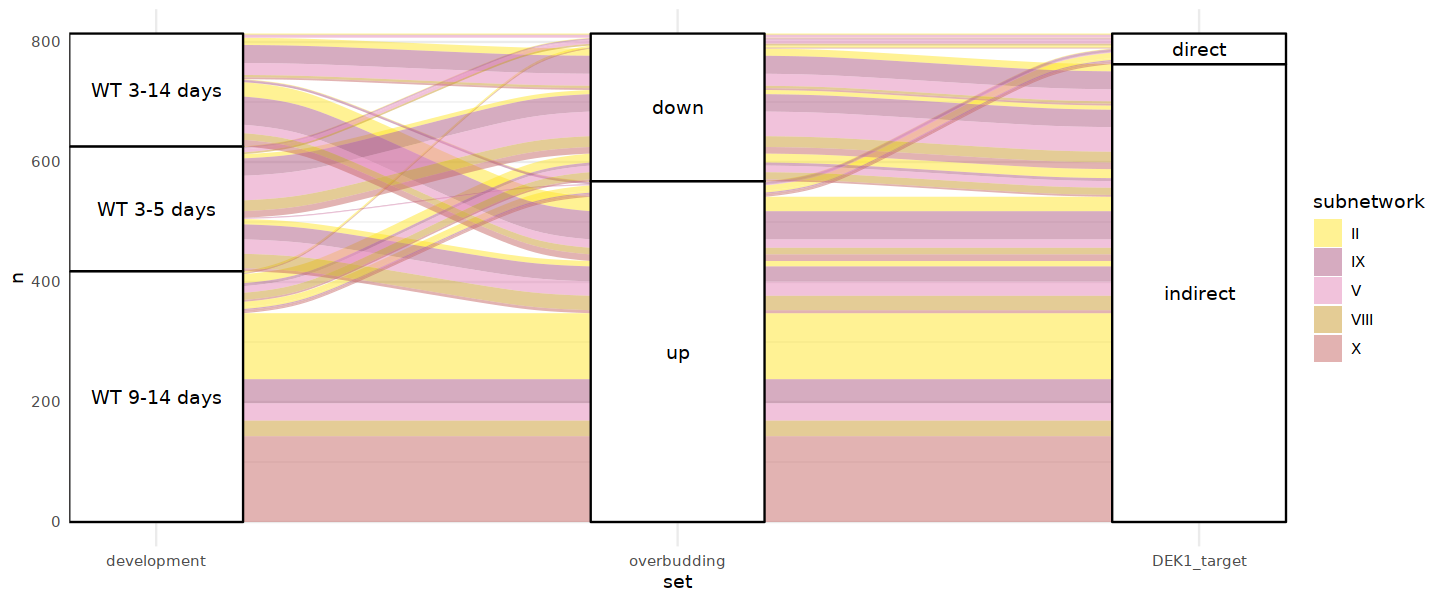

In [45]:
PPa=P %>% count(subnetwork,development,overbudding,DEK1_target) %>% 
    filter(development != "unchanged" & subnetwork %in% c("II","V","VIII","IX","X") 
               & ! DEK1_target == "no" & ! overbudding =="unchanged") %>%
    mutate(DEK1_target=ifelse(DEK1_target=="indirect","indirect","direct"))
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(PPa)),
                              key = "set",
                              axes = c(2:4))
head(PPP)

#levels(PPP$mutant_pattern)
#PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
#levels(PPP$mutant_pattern)
#table(PPP$mutant_pattern)


options(repr.plot.width=12, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        #scale_fill_brewer(palette="Set1")+
        scale_fill_manual(values=col2) +
        geom_alluvium(aes(fill=subnetwork)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

subnetwork,development,overbudding,DEK1_target,n
<chr>,<chr>,<chr>,<chr>,<int>
II,WT 3-14 days,down,direct,2
II,WT 3-14 days,up,direct,1
II,WT 3-5 days,down,direct,1
II,WT 9-14 days,down,direct,2
II,WT 9-14 days,down,direct,1
II,WT 9-14 days,up,direct,9


,subnetwork,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,II,2,1,development,WT 3-14 days
2,II,1,2,development,WT 3-14 days
3,II,1,3,development,WT 3-5 days
4,II,2,4,development,WT 9-14 days
5,II,1,5,development,WT 9-14 days
6,II,9,6,development,WT 9-14 days


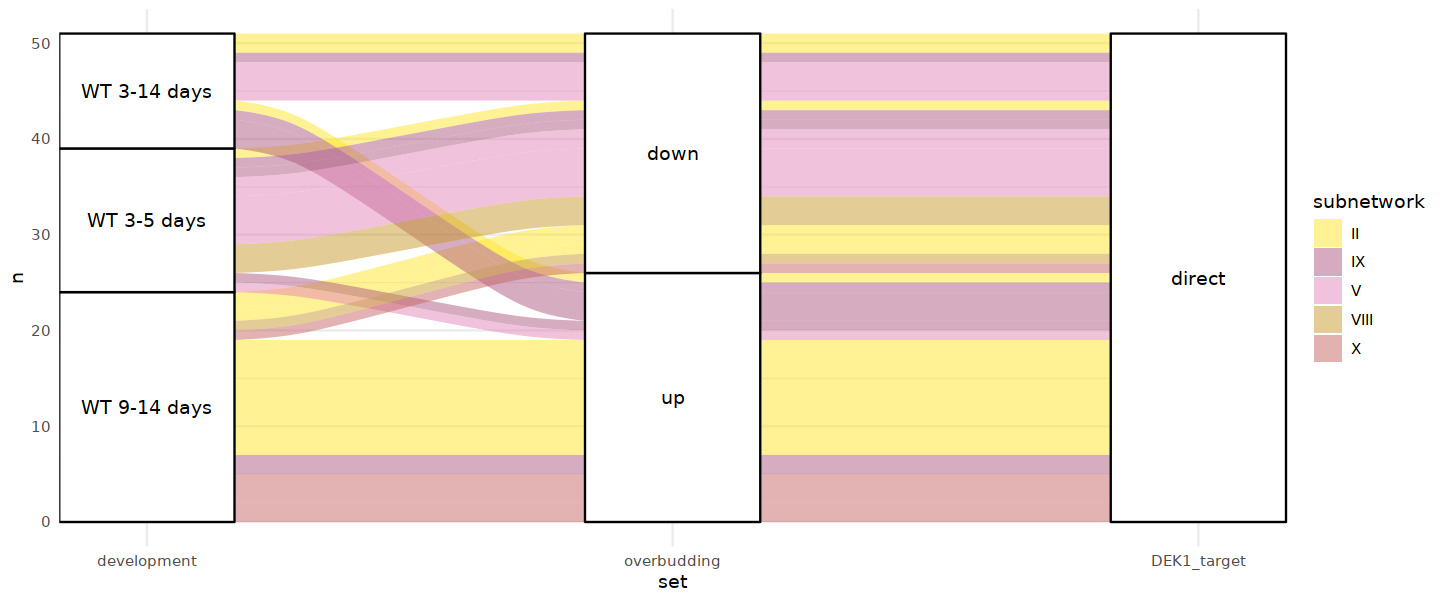

In [47]:
PPa=P %>% count(subnetwork,development,overbudding,DEK1_target) %>% 
    filter(development != "unchanged" & subnetwork %in% c("II","V","VIII","IX","X") 
               & ! DEK1_target == "no" & ! overbudding =="unchanged" & !DEK1_target=="indirect") %>%
    mutate(DEK1_target=ifelse(DEK1_target=="indirect","indirect","direct"))
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(PPa)),
                              key = "set",
                              axes = c(2:4))
head(PPP)

#levels(PPP$mutant_pattern)
#PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
#levels(PPP$mutant_pattern)
#table(PPP$mutant_pattern)


options(repr.plot.width=12, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        #scale_fill_brewer(palette="Set1")+
        scale_fill_manual(values=col2) +
        geom_alluvium(aes(fill=subnetwork)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

subnetwork,development,overbudding,overbudding_filaments,n
<chr>,<chr>,<chr>,<chr>,<int>
II,WT 3-14 days,down,unchanged,2
II,WT 3-14 days,up,unchanged,1
II,WT 3-5 days,down,unchanged,1
II,WT 9-14 days,down,down,1
II,WT 9-14 days,down,unchanged,2
II,WT 9-14 days,up,unchanged,5


subnetwork,n,alluvium,set,stratum
<chr>,<int>,<int>,<fct>,<fct>
II,2,1,development,WT 3-14 days
II,1,2,development,WT 3-14 days
II,1,3,development,WT 3-5 days
II,1,4,development,WT 9-14 days
II,2,5,development,WT 9-14 days
II,5,6,development,WT 9-14 days


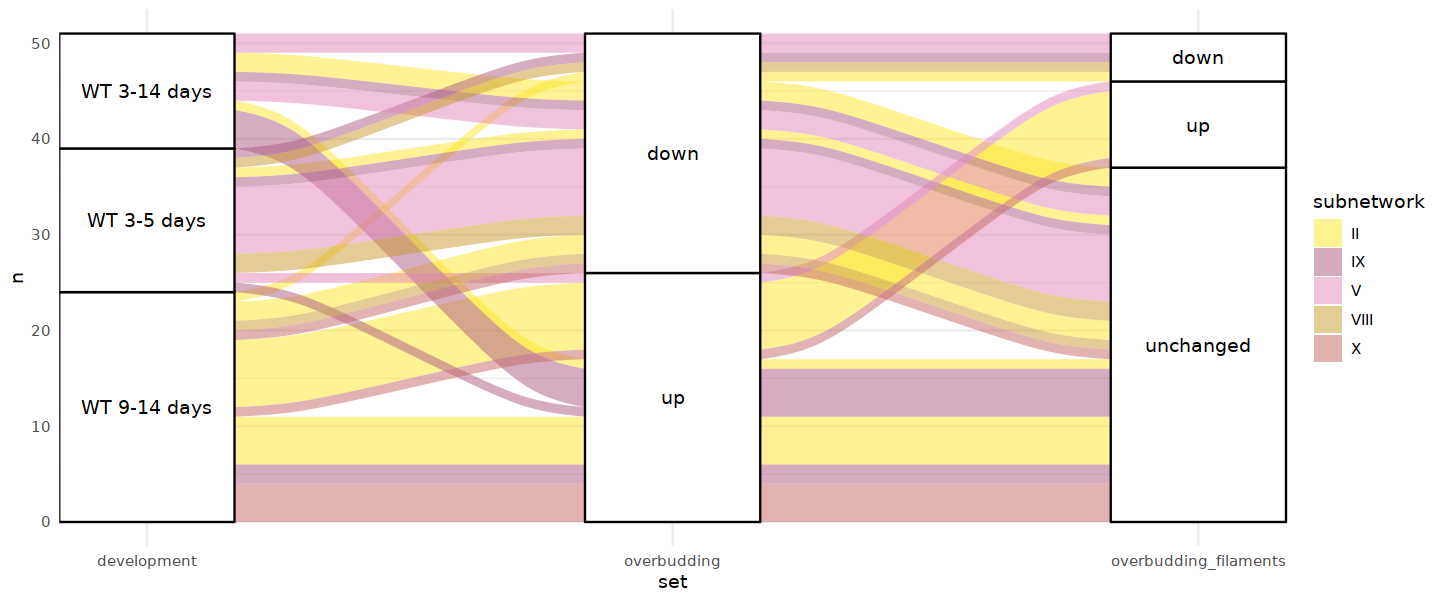

In [26]:
PPPa=droplevels(subset(Pna,! DEK1_target %in% c("no","indirect") &
          development != "unchanged" & 
           subnetwork %in% c("II","V","VIII","IX","X") & 
           ! overbudding =="unchanged")) 
PPa = PPPa %>%    count(subnetwork,development,overbudding,overbudding_filaments)
head(PPa)
PPP=to_lodes_form(PPa,
                              key = "set",
                              axes = c(2:4))
head(PPP)

#levels(PPP$mutant_pattern)
#PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
#levels(PPP$mutant_pattern)
#table(PPP$mutant_pattern)


options(repr.plot.width=12, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        #scale_fill_brewer(palette="Set1")+
        scale_fill_manual(values=col2) +
        geom_alluvium(aes(fill=subnetwork)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

subnetwork,development,overbudding,overbudding_filaments,n
<chr>,<chr>,<chr>,<chr>,<int>
II,unchanged,down,down,1
II,unchanged,down,unchanged,4
II,unchanged,up,up,2
II,WT 3-14 days,down,unchanged,2
II,WT 3-14 days,up,unchanged,1
II,WT 3-5 days,down,unchanged,1


subnetwork,n,alluvium,set,stratum
<chr>,<int>,<int>,<fct>,<fct>
II,1,1,development,unchanged
II,4,2,development,unchanged
II,2,3,development,unchanged
II,2,4,development,WT 3-14 days
II,1,5,development,WT 3-14 days
II,1,6,development,WT 3-5 days


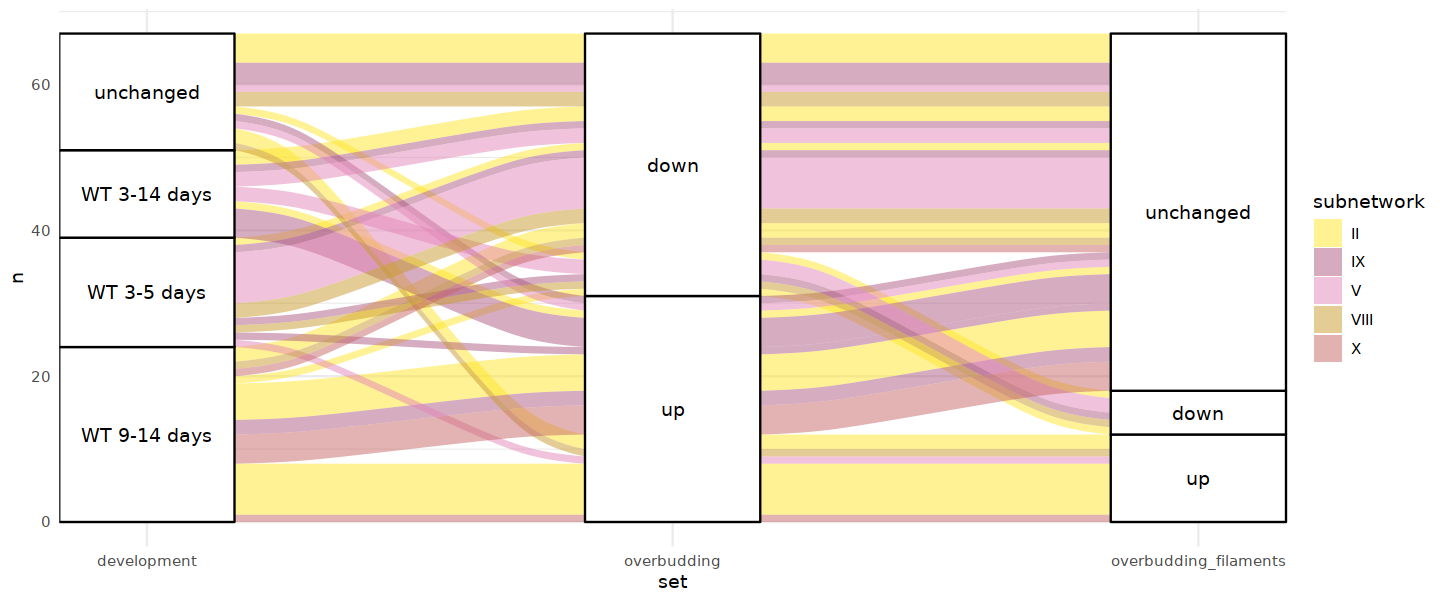

In [27]:
PPPa=droplevels(subset(Pna,! DEK1_target %in% c("no","indirect") &
          #development != "unchanged" & 
           subnetwork %in% c("II","V","VIII","IX","X") & 
           ! overbudding =="unchanged")) 
PPa = PPPa %>%    count(subnetwork,development,overbudding,overbudding_filaments)
head(PPa)
PPP=to_lodes_form(PPa,
                              key = "set",
                              axes = c(2:4))
head(PPP)

#levels(PPP$mutant_pattern)
#PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
#levels(PPP$mutant_pattern)
#table(PPP$mutant_pattern)


options(repr.plot.width=12, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        #scale_fill_brewer(palette="Set1")+
        scale_fill_manual(values=col2) +
        geom_alluvium(aes(fill=subnetwork)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

subnetwork,mutant_pattern,development,DEK1_target,n
<chr>,<chr>,<chr>,<chr>,<int>
I,activator target,unchanged,both,1
I,activator target,unchanged,indirect,35
I,activator target,unchanged,no,9
I,activator target,WT 3-14 days,both,1
I,activator target,WT 3-14 days,indirect,28
I,activator target,WT 3-14 days,no,10


,mutant_pattern,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,activator target,1,1,subnetwork,II
2,activator target,51,2,subnetwork,II
3,activator target,2,3,subnetwork,II
4,activator target,16,4,subnetwork,II
5,activator target,5,5,subnetwork,II
6,activator target,11,6,subnetwork,II


NULL

[1] "repressor target"           "activator target"          
[3] "TF with deregulated target"


          repressor target           activator target 
                       132                        114 
TF with deregulated target 
                        78 

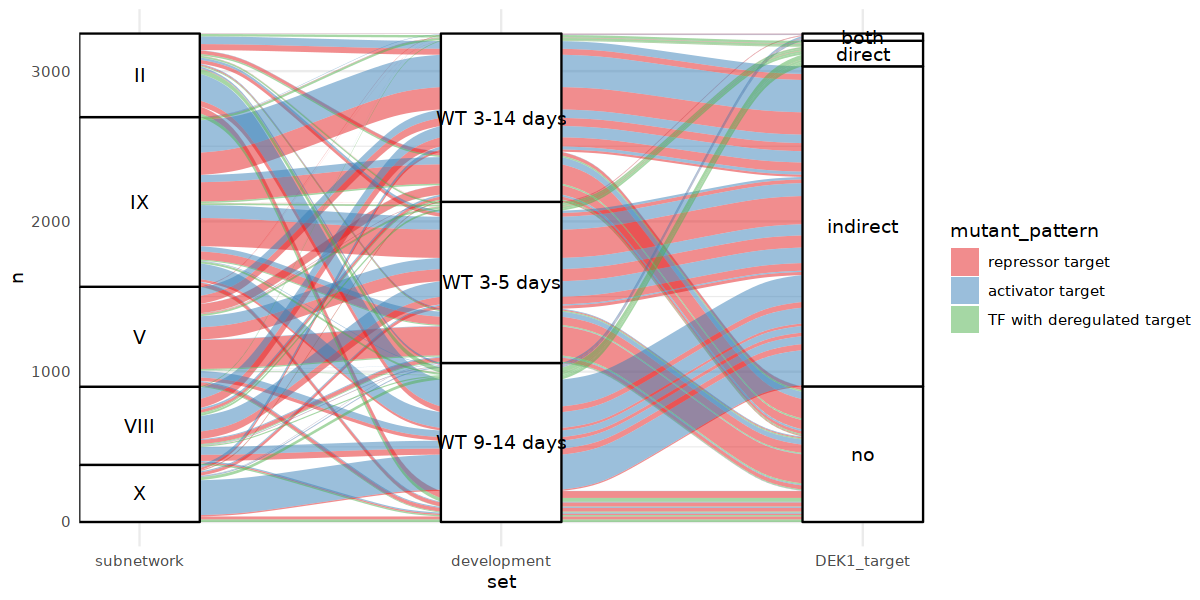

In [32]:
PPa=P %>% count(subnetwork,mutant_pattern,development,DEK1_target)
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(subset(PPa,development != "unchanged" & subnetwork %in% c("II","V","VIII","IX","X")))),
                              key = "set",
                              axes = c(1,3,4))
head(PPP)

levels(PPP$mutant_pattern)
PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
levels(PPP$mutant_pattern)
table(PPP$mutant_pattern)


options(repr.plot.width=10, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

mutant_pattern,development,DEK1_target,n
<chr>,<chr>,<chr>,<int>
activator target,unchanged,both,11
activator target,unchanged,indirect,497
activator target,WT 3-14 days,both,9
activator target,WT 3-14 days,direct,1
activator target,WT 3-14 days,indirect,578
activator target,WT 3-5 days,both,3


,mutant_pattern,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,activator target,11,1,development,unchanged
2,activator target,497,2,development,unchanged
3,activator target,9,3,development,WT 3-14 days
4,activator target,1,4,development,WT 3-14 days
5,activator target,578,5,development,WT 3-14 days
6,activator target,3,6,development,WT 3-5 days


NULL

[1] "repressor target"           "activator target"          
[3] "TF with deregulated target"


          repressor target           activator target 
                        24                         20 
TF with deregulated target 
                         8 

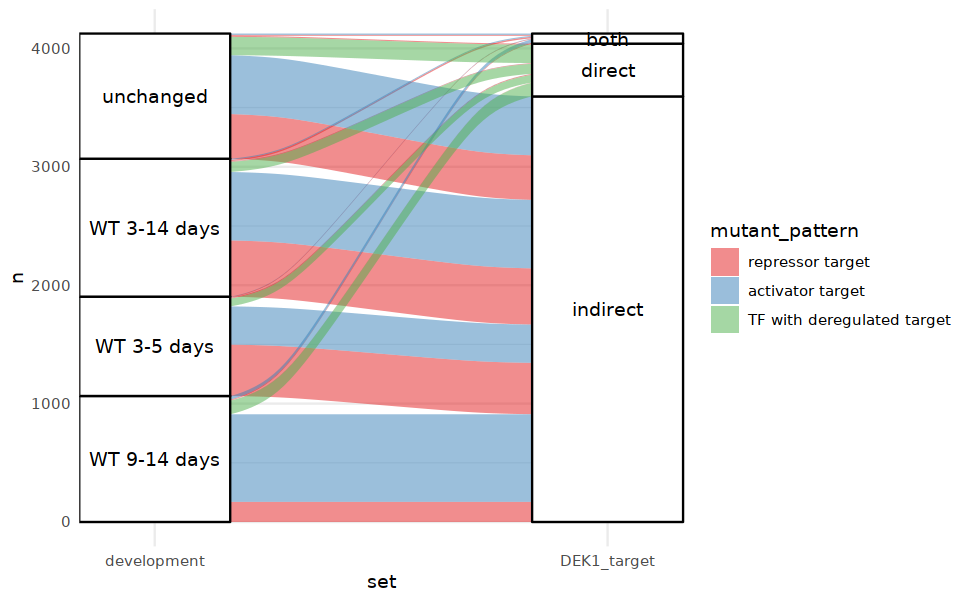

In [137]:
PPa=P %>% #filter(subnetwork %in% c("II","V","VIII","IX","X")) %>% 
                 count(mutant_pattern,development,DEK1_target) %>% 
        filter(DEK1_target!= "no")
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(PPa)),
                              key = "set",
                              axes = c(2,3))
head(PPP)

levels(PPP$mutant_pattern)
PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
levels(PPP$mutant_pattern)
table(PPP$mutant_pattern)


options(repr.plot.width=8, repr.plot.height=5)
gg=ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .02)) +
        #scale_y_continuous(trans="sqrt",) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 
print(gg)
#ggsave(gg,filename="alluvial.subnetwork.vs.DEK1_targets.pdf",width=8,height=5)

mutant_pattern,DEK1_target,overbudding,overbudding_filaments,n
<chr>,<chr>,<chr>,<chr>,<int>
activator target,both,unchanged,unchanged,26
activator target,both,unchanged,up,1
activator target,both,up,unchanged,15
activator target,both,up,up,11
activator target,direct,unchanged,unchanged,1
activator target,direct,up,unchanged,1


,mutant_pattern,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,activator target,15,1,DEK1_target,both
2,activator target,11,2,DEK1_target,both
3,activator target,1,3,DEK1_target,direct
4,activator target,665,4,DEK1_target,indirect
5,activator target,189,5,DEK1_target,indirect
6,activator target,64,6,DEK1_target,no


NULL

[1] "repressor target"           "activator target"          
[3] "TF with deregulated target"


          repressor target           activator target 
                        24                         21 
TF with deregulated target 
                        24 

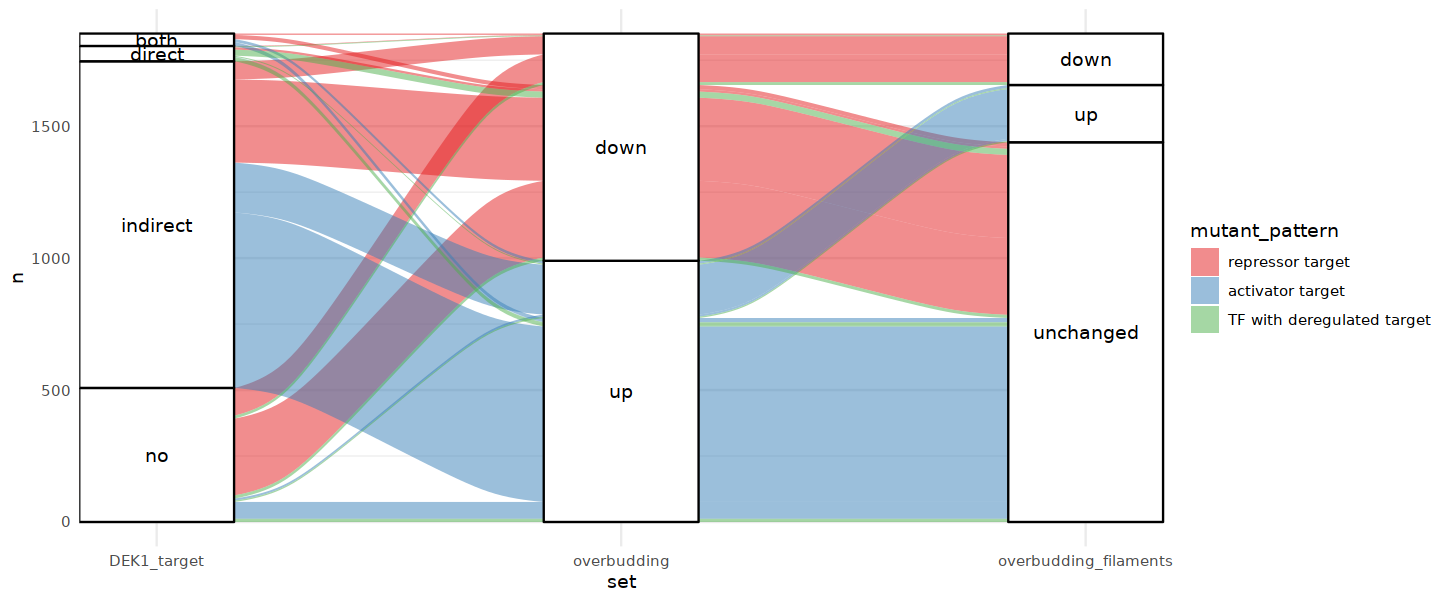

In [38]:
PPa=P %>% count(mutant_pattern,DEK1_target,overbudding,overbudding_filaments)
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(subset(PPa,overbudding != "unchanged"))),
                              key = "set",
                              axes = c(2,3,4))
head(PPP)

levels(PPP$mutant_pattern)
PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
levels(PPP$mutant_pattern)
table(PPP$mutant_pattern)


options(repr.plot.width=12, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

subnetwork,mutant_pattern,overbudding,n
<chr>,<chr>,<chr>,<int>
I,activator target,unchanged,78
I,activator target,up,45
I,repressor target,down,64
I,repressor target,unchanged,140
I,TF with deregulated target,down,9
I,TF with deregulated target,unchanged,86


,mutant_pattern,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,activator target,181,1,subnetwork,II
2,repressor target,96,2,subnetwork,II
3,TF with deregulated target,11,3,subnetwork,II
4,TF with deregulated target,6,4,subnetwork,II
5,activator target,188,5,subnetwork,IX
6,repressor target,132,6,subnetwork,IX


NULL

[1] "repressor target"           "activator target"          
[3] "TF with deregulated target"


          repressor target           activator target 
                        10                         10 
TF with deregulated target 
                        20 

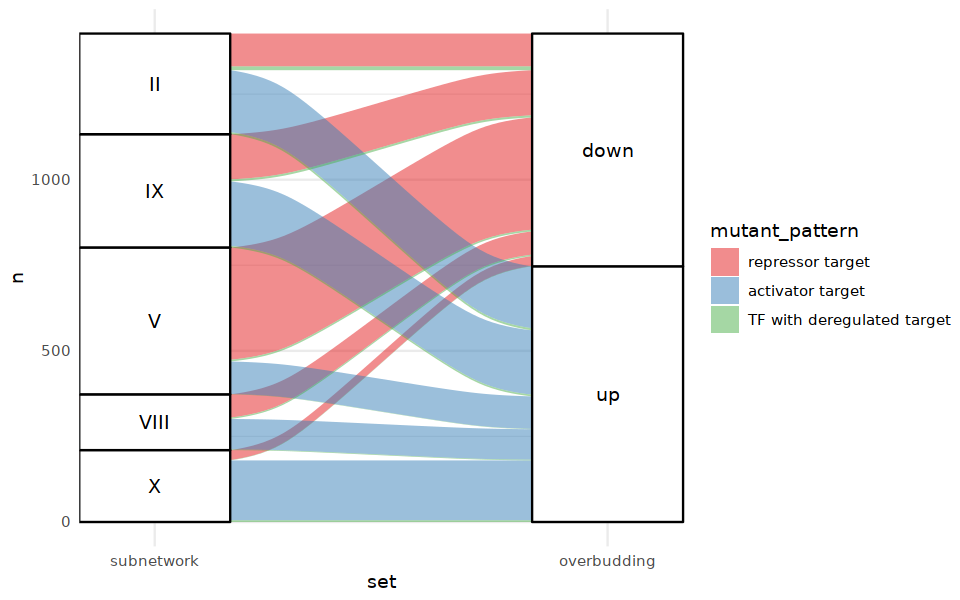

In [39]:
PPa=P %>% count(subnetwork,mutant_pattern,overbudding)
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(subset(PPa,overbudding != "unchanged"& subnetwork %in% c("II","V","VIII","IX","X")))),
                              key = "set",
                              axes = c(1,3))
head(PPP)

levels(PPP$mutant_pattern)
PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
levels(PPP$mutant_pattern)
table(PPP$mutant_pattern)


options(repr.plot.width=8, repr.plot.height=5)
ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 

subnetwork,mutant_pattern,DEK1_target,n
<chr>,<chr>,<chr>,<int>
II,activator target,both,15
II,activator target,indirect,283
II,repressor target,both,10
II,repressor target,direct,2
II,repressor target,indirect,142
II,TF with deregulated target,direct,83


,mutant_pattern,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,activator target,15,1,subnetwork,II
2,activator target,283,2,subnetwork,II
3,repressor target,10,3,subnetwork,II
4,repressor target,2,4,subnetwork,II
5,repressor target,142,5,subnetwork,II
6,TF with deregulated target,83,6,subnetwork,II


NULL

[1] "repressor target"           "activator target"          
[3] "TF with deregulated target"


          repressor target           activator target 
                        28                         22 
TF with deregulated target 
                        10 

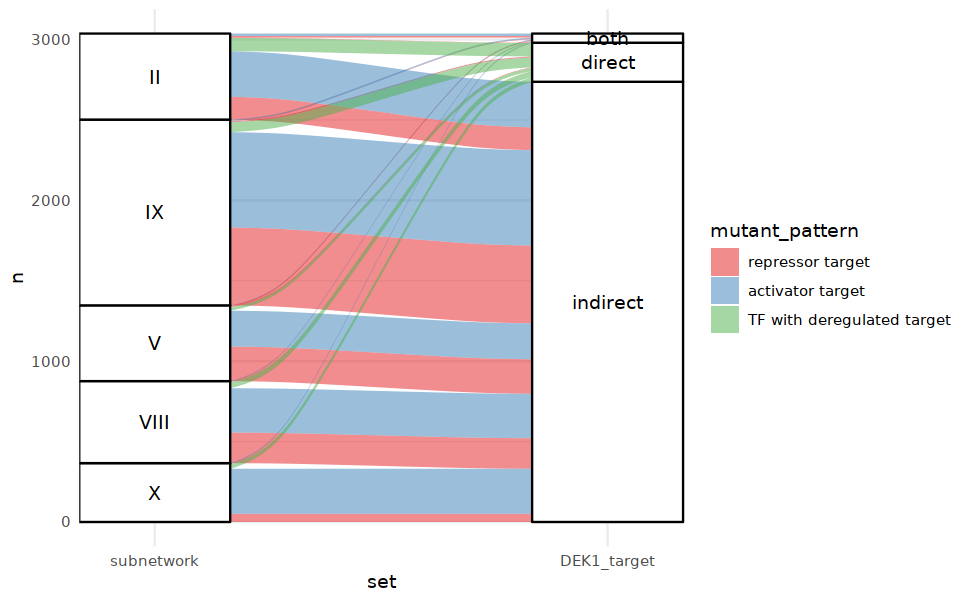

In [138]:
PPa=P %>% 
    filter(subnetwork %in% c("II","V","VIII","IX","X") & DEK1_target!= "no")  %>% 
    count(subnetwork,mutant_pattern,DEK1_target)
head(PPa)
PPP=to_lodes_form(data.frame(droplevels(PPa)),
                              key = "set",
                              axes = c(1,3))
head(PPP)

levels(PPP$mutant_pattern)
PPP$mutant_pattern=factor(PPP$mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))
levels(PPP$mutant_pattern)
table(PPP$mutant_pattern)


options(repr.plot.width=8, repr.plot.height=5)
gg=ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
       # scale_y_continuous(trans="sqrt",) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 
print(gg)
#ggsave(gg,filename="alluvial.subnetwork.vs.DEK1_targets.pdf",width=8,height=5)

In [87]:
DEK1controlled=c("II","V","X","VIII","IX")

subnetwork,DEK1_target,mutant_pattern,n
<chr>,<chr>,<fct>,<int>
II,direct,repressor target,12
II,direct,activator target,15
II,direct,TF with deregulated target,83
II,indirect,repressor target,142
II,indirect,activator target,283
IX,direct,repressor target,9


,mutant_pattern,n,alluvium,set,stratum
,<fct>,<int>,<int>,<fct>,<fct>
1,repressor target,12,1,subnetwork,II
2,activator target,15,2,subnetwork,II
3,TF with deregulated target,83,3,subnetwork,II
4,repressor target,142,4,subnetwork,II
5,activator target,283,5,subnetwork,II
6,repressor target,9,6,subnetwork,IX


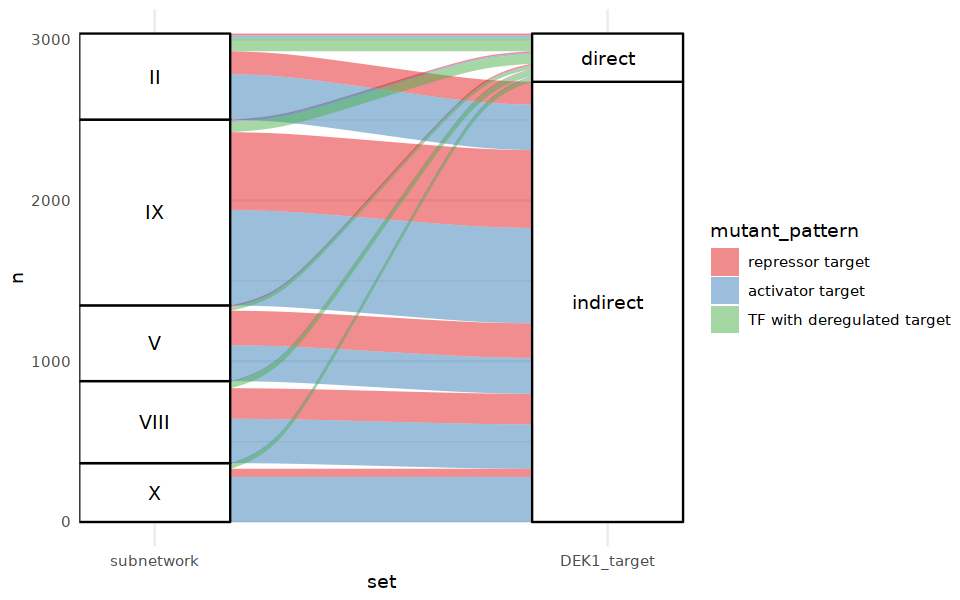

In [102]:
PPa=P %>%
    mutate(mutant_pattern=factor(mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))) %>%
    mutate(DEK1_target=ifelse(DEK1_target=="both","direct",DEK1_target)) %>%
    select(geneid,subnetwork,mutant_pattern,DEK1_target) %>%
    distinct() %>%
    filter(subnetwork %in% DEK1controlled & DEK1_target!= "no") %>%
    count(subnetwork, DEK1_target, mutant_pattern)

head(PPa)

PPP=to_lodes_form(data.frame(droplevels(PPa)),
                              key = "set",
                              axes = c(1,2))
head(PPP)

options(repr.plot.width=8, repr.plot.height=5)
gg=ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        #scale_y_continuous(trans="sqrt",) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 
print(gg)
ggsave(gg,filename="alluvial.subnetwork.vs.DEK1_targets.pdf",width=8,height=5)

main figure.

subnetwork,DEK1_target,mutant_pattern,n
<chr>,<chr>,<fct>,<int>
I,direct,repressor target,4
I,direct,activator target,3
I,direct,TF with deregulated target,71
I,indirect,repressor target,126
I,indirect,activator target,98
II,direct,repressor target,12


,mutant_pattern,n,alluvium,set,stratum
,<fct>,<int>,<int>,<fct>,<fct>
1,repressor target,4,1,subnetwork,I
2,activator target,3,2,subnetwork,I
3,TF with deregulated target,71,3,subnetwork,I
4,repressor target,126,4,subnetwork,I
5,activator target,98,5,subnetwork,I
6,repressor target,12,6,subnetwork,II


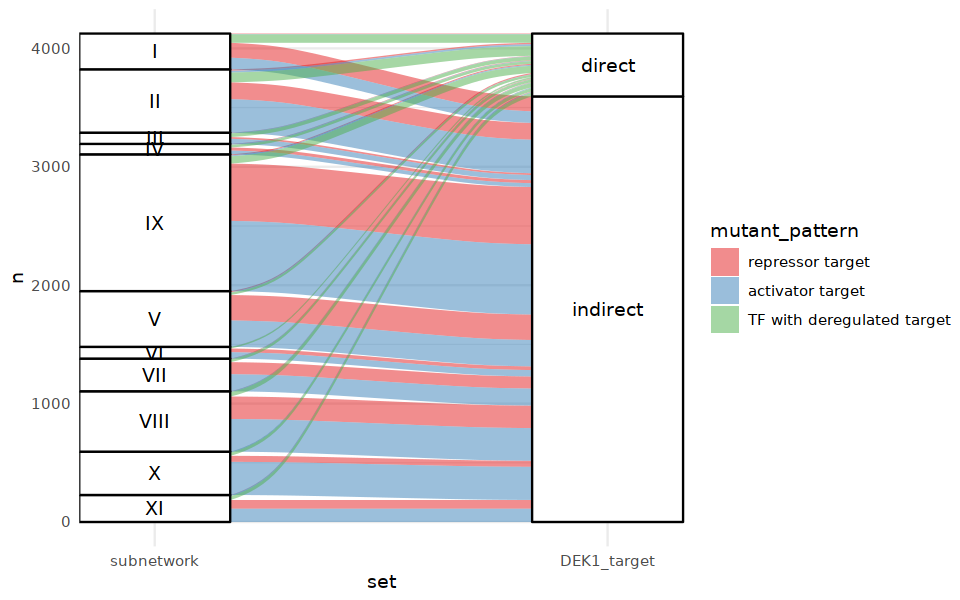

In [164]:
PPa=P %>%
    mutate(mutant_pattern=factor(mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))) %>%
    mutate(DEK1_target=ifelse(DEK1_target=="both","direct",DEK1_target)) %>%
    select(geneid,subnetwork,mutant_pattern,DEK1_target) %>%
    distinct() %>%
    filter(DEK1_target!= "no") %>%
    count(subnetwork, DEK1_target, mutant_pattern)

head(PPa)

PPP=to_lodes_form(data.frame(droplevels(PPa)),
                              key = "set",
                              axes = c(1,2))
head(PPP)

options(repr.plot.width=8, repr.plot.height=5)
gg=ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        #scale_y_continuous(trans="sqrt",) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 
print(gg)
ggsave(gg,filename="alluvial.all_subnetwork.vs.DEK1_targets.pdf",width=8,height=5)

supplementary plot

[1] 1362

subnetwork,DEK1_target,overbudding,n
<chr>,<chr>,<chr>,<int>
II,direct,down,11
II,direct,up,15
II,indirect,down,48
II,indirect,up,165
II,no,down,48
II,no,up,7


,subnetwork,n,alluvium,set,stratum
,<chr>,<int>,<int>,<fct>,<fct>
1,II,11,1,DEK1_target,direct
2,II,15,2,DEK1_target,direct
3,II,48,3,DEK1_target,indirect
4,II,165,4,DEK1_target,indirect
5,II,48,5,DEK1_target,no
6,II,7,6,DEK1_target,no


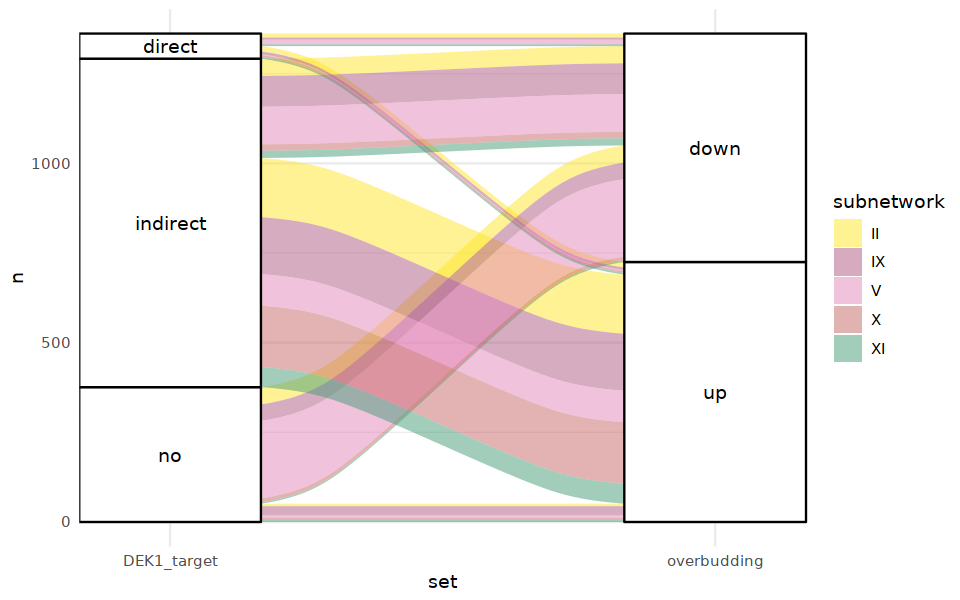

In [142]:
enriched=c("II","V","IX","X","XI")
PPa=P %>%
    mutate(mutant_pattern=factor(mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))) %>%
    mutate(DEK1_target=ifelse(DEK1_target=="both","direct",DEK1_target)) %>%
    filter(subnetwork %in% enriched & overbudding!= "unchanged") 
    #filter( overbudding!= "unchanged") %>%
nrow(PPa)
PPa=PPa %>%
    count(subnetwork, DEK1_target,overbudding)

head(PPa)

PPP=to_lodes_form(data.frame(droplevels(PPa)),
                              key = "set",
                              axes = c(2,3))
head(PPP)

options(repr.plot.width=8, repr.plot.height=5)
gg=ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        scale_fill_manual(values=col2)+
        geom_alluvium(aes(fill=subnetwork)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 
print(gg)
ggsave(gg,filename="alluvial.overbudding.vs.DEK1_targets.pdf",width=8,height=5)

[1] 1362

mutant_pattern,subnetwork,DEK1_target,overbudding,n
<fct>,<chr>,<chr>,<chr>,<int>
repressor target,II,direct,down,9
repressor target,II,indirect,down,48
repressor target,II,no,down,39
repressor target,IX,direct,down,2
repressor target,IX,indirect,down,86
repressor target,IX,no,down,44


,mutant_pattern,n,alluvium,set,stratum
,<fct>,<int>,<int>,<fct>,<fct>
1,repressor target,9,1,subnetwork,II
2,repressor target,48,2,subnetwork,II
3,repressor target,39,3,subnetwork,II
4,repressor target,2,4,subnetwork,IX
5,repressor target,86,5,subnetwork,IX
6,repressor target,44,6,subnetwork,IX


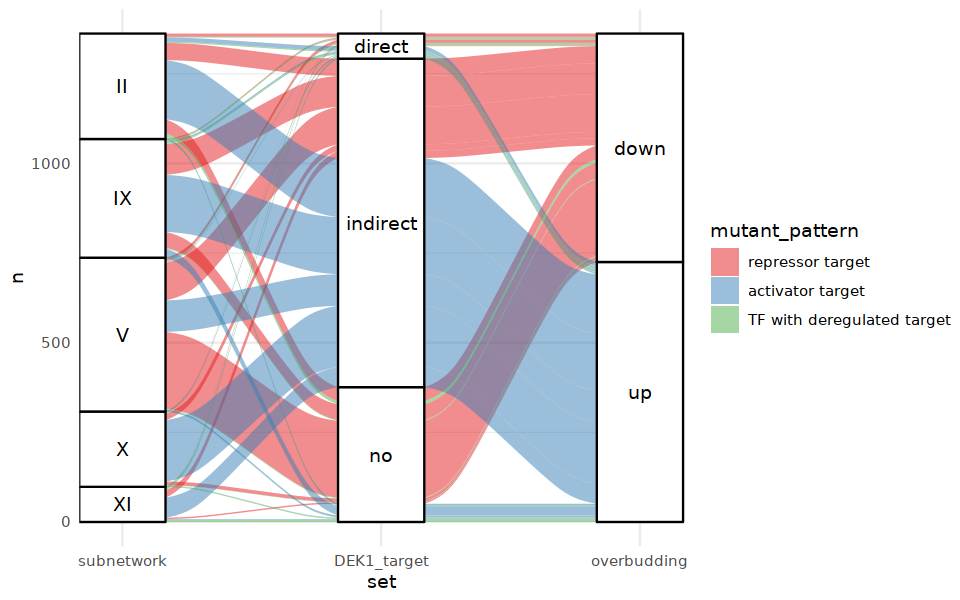

In [148]:
PPa=P %>%
    mutate(mutant_pattern=factor(mutant_pattern,levels=c("repressor target","activator target","TF with deregulated target"))) %>%
    mutate(DEK1_target=ifelse(DEK1_target=="both","direct",DEK1_target)) %>%
    filter(subnetwork %in% enriched & overbudding!= "unchanged") 
nrow(PPa)
PPa=PPa %>%
    #filter( overbudding!= "unchanged") %>%
    count(mutant_pattern,subnetwork, DEK1_target,overbudding)

head(PPa)

PPP=to_lodes_form(data.frame(droplevels(PPa)),
                              key = "set",
                              axes = c(2,3,4))
head(PPP)

options(repr.plot.width=8, repr.plot.height=5)
gg=ggplot(PPP,
        aes(x=set,stratum=stratum,alluvium = alluvium,y=n,label=stratum)) +
        scale_x_discrete( expand = c(.01, .01)) +
        scale_fill_brewer(palette="Set1")+
        geom_alluvium(aes(fill=mutant_pattern)) +
          geom_stratum() + geom_text(stat = "stratum") +
          theme_minimal() 
print(gg)
#ggsave(gg,filename="alluvial.overbudding.vs.DEK1_targets.pdf",width=8,height=5)